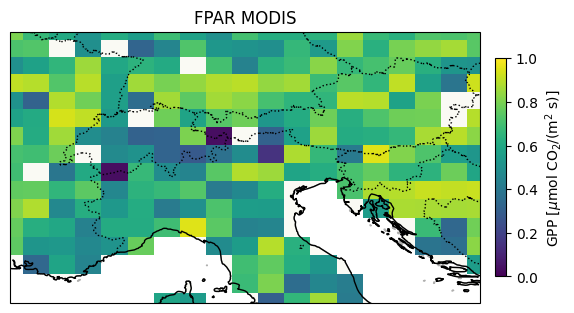

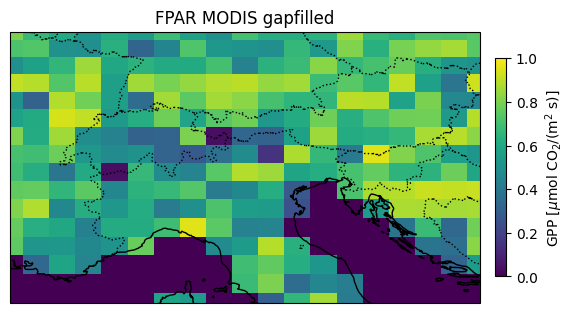

PModelEnvironment(shape=(1, 16, 19))
Attr           Mean       Min        Max    NaN  Units
---------  --------  --------  ---------  -----  -------
tc            24.81      9.93      38.82      0  °C
vpd         1504.61     67.23    6109.09      0  Pa
co2          385.44    353.02     412.9       0  ppm
patm       95734.8   79145.2   102203         0  Pa
ca            36.92     29.81      41.47      0  Pa
gammastar      4.27      1.68       8.56      0  Pa
kmm           79.11     17.93     232.3       0  Pa
ns_star        1.02      0.75       1.47      0  -


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
import xarray as xr
from pyrealm.pmodel import PModel, PModelEnvironment
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import generic_filter


# Load WRF dataset
# wrf_paths
# "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20250107_155336_ALPS_3km",
# "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20250105_193347_ALPS_9km",
# "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241229_112716_ALPS_27km",
# "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241227_183215_ALPS_54km",
day = 1
wrf_path = f"/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241227_183215_ALPS_54km/wrfout_d01_2012-07-{day:02d}_12:00:00"
wrf_ds = xr.open_dataset(wrf_path)

# Load variables from WRF dataset 
temp = wrf_ds["T2"].to_numpy() - 273.15  # Convert to Celsius
patm = wrf_ds["PSFC"].to_numpy()  # Pa
co2 = wrf_ds["CO2_BIO"].isel(bottom_top=0).to_numpy()  # ppmv
qvapor = wrf_ds["QVAPOR"].isel(bottom_top=0).to_numpy()  # Water vapor mixing ratio (kg/kg) at the surface level
psfc = wrf_ds["PSFC"].isel(Time=0).to_numpy()            # Surface pressure (Pa)
t2 = wrf_ds["T2"].isel(Time=0).to_numpy()                # Temperature at 2m (K)

# Calculate actual vapor pressure (ea) in kPa
ea = (qvapor * psfc) / (0.622 + qvapor)  # Pa 
# Calculate saturation vapor pressure (es) in kPa
es = 0.6108 * np.exp((17.27 * temp) / (temp + 237.3)) * 1000 # convert to Pa
# Calculate VPD
vpd = np.maximum(0, es - ea)  # Force non-negative VPD


# Load required variables from WRF dataset
vegfra = wrf_ds["VEGFRA"].to_numpy()   # Vegetation fraction (0 to 1)
albedo = wrf_ds["ALBEDO"].to_numpy()   # Albedo (0 to 1)
swdown = wrf_ds["SWDOWN"].to_numpy()   # Downward shortwave radiation (W/m^2)
ppfd = swdown * 2.30785 # Shortwave radiation (W/m²) × 0.505 -> PAR (W/m²) × 4.57 -> 2.3*x ~ PPFD (umol/m²/s)
xlat = wrf_ds["XLAT"].to_numpy()       # Latitude (degrees)
xlon = wrf_ds["XLONG"].to_numpy()      # Longitude (degrees)
xlat = xlat[0, :,:]
xlon = xlon[0, :,:]
fapar_wrf = (1 - albedo) * (vegfra/100) # Calculate fAPAR

# get modis fpar
modis_path = "/scratch/c7071034/DATA/MODIS/MODIS_FPAR/fpar_interpol/interpolated_fpar_54km_2012-07-01T12:00:00.nc"
modis_ds = xr.open_dataset(modis_path)
fpar_modis = modis_ds["Fpar_500m"].to_numpy()  # fAPAR from MODIS

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=1)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, fpar_modis[0, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
plt.title("FPAR MODIS")
plt.show()

# where modis is nan use values from fapar_wrf
fpar_modis = np.where(np.isnan(fpar_modis), fapar_wrf, fpar_modis) # TODO: how is this handled in literature? There is no fPAR Data around cities, so these areas could also be masked out, but I would habe to modify the landcover maps... 

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=1)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, fpar_modis[0, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
plt.title("FPAR MODIS gapfilled")
plt.show()


# Ensure proper dimensions and clean invalid data
temp[temp < -25] = np.nan  # Mask temperatures below -25°C
vpd = np.clip(vpd, 0, np.inf)  # Force VPD ≥ 0

# Run P-model environment
env = PModelEnvironment(tc=temp, co2=co2, patm=patm, vpd=vpd)
env.summarize()

# Estimate productivity
model = PModel(env)
model.estimate_productivity(fpar_modis, ppfd)

gC_to_mumol = 0.0833  # 1 µg C m⁻² s⁻¹ × (1 µmol C / 12.01 µg C) × (1 µmol CO₂ / 1 µmol C) = 0.0833 µmol CO₂ m⁻² s⁻¹
data = model.gpp[0, :, :] * gC_to_mumol


In [ ]:




fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=40)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
plt.title("GPP from Postprocessing WRF Output with P Model")
plt.show()


In [13]:
wrf_gpp = wrf_ds["EBIO_GEE"].isel(Time=0).to_numpy() 
wrf_gpp *= -1/3600
def nanmean_filter(values):
    return np.nanmean(values)
wrf_gpp_filtered = generic_filter(wrf_gpp, nanmean_filter, size=3, mode='constant', cval=np.nan)
wrf_gpp_filtered = np.where(np.isnan(wrf_gpp), wrf_gpp_filtered, wrf_gpp)

In [ ]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=40)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, wrf_gpp_filtered[0,:,:], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
plt.title("GPP from WRF VPRM")
plt.show()


In [ ]:
# Assuming wrf_gpp, model.gpp, gC_to_mumol, xlon, xlat are defined earlier
data = wrf_gpp[0, :, :] - model.gpp[0, :, :] * gC_to_mumol

# Create a map with a PlateCarree projection (a simple lat/lon projection)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS)
vmin, vmax = -20, 20
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.bwr
mesh = ax.pcolormesh(xlon, xlat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
ax.set_title("GPP Difference (WRF_VPRM - P_Model)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show plot
plt.show()
